# Text classification model for SPAM detection using Deep learning models in TensorFlow Keras.

## Importing Libraries and packages

In [ ]:
import nltk
import pandas as pd
import numpy as np
import string
import gensim
from numpy import asarray, zeros
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
import re
from nltk.tokenize import word_tokenize as wt
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, 
                             mean_squared_error, log_loss, precision_recall_curve, classification_report, 
                             precision_recall_fscore_support)
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import seaborn as sns

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Bidirectional
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = stopwords.words('english')
custom_stopwords = ['u', 'im', 'c']
stop_words = stop_words + custom_stopwords

In [ ]:
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

In [ ]:
ps = nltk.PorterStemmer()

In [ ]:
nltk.download("wordnet")
nltk.download('omw-1.4')
wn = nltk.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Loading data

In [ ]:
spam_df = pd.read_csv('drive/MyDrive/assignment_3/spam.csv')

In [ ]:
spam_df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data Cleaning

In [ ]:
spam_df.shape

(5572, 2)

In [ ]:
spam_df[spam_df['label'] == 'spam'].count()

label    747
text     747
dtype: int64

In [ ]:
spam_df[spam_df['label'] == 'ham'].count()

label    4825
text     4825
dtype: int64

#### Checking for null/na values

In [ ]:
spam_df.isnull().sum()

label    0
text     0
dtype: int64

In [ ]:
spam_df.isna().sum()

label    0
text     0
dtype: int64

#### Removing duplicates values 

In [ ]:
spam_df.drop_duplicates(inplace = True)

## Data Preprocessing

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
    
def preprocess_text(inputSentence):
    # Removing html tags
    sentence = remove_tags(inputSentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

def clean_text(text):
  text_nopunct = preprocess_text(text)
  text_nopunct = ''.join([char.lower() for char in text if char not in string.punctuation])
  tokens = re.split('\W+',text_nopunct)
  text = [ps.stem(text) for text in tokens if text not in stop_words]
  return text

In [ ]:
vector_df = spam_df[['label','text']]

In [ ]:
x = vector_df['text']
y = vector_df['label']

#### Label encoding

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y) 

In [ ]:
list(le.classes_)

['ham', 'spam']

## Bag of Words using Count Vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=clean_text)
X_count = count_vect.fit_transform(x)
print(X_count.shape)
print(count_vect.get_feature_names())
print(len(count_vect.vocabulary_))

(5158, 8057)
['', '0', '008704050406', '0089mi', '0121', '01223585236', '01223585334', '0125698789', '02', '020603', '0207', '02070836089', '02072069400', '02073162414', '02085076972', '020903', '021', '050703', '0578', '06', '060505', '061104', '07008009200', '07046744435', '07090201529', '07090298926', '07099833605', '071104', '07123456789', '0721072', '07732584351', '07734396839', '07742676969', '07753741225', '0776xxxxxxx', '07786200117', '077xxx', '078', '07801543489', '07808', '07808247860', '07808726822', '07815296484', '07821230901', '0784987', '0789xxxxxxx', '0794674629107880867867', '0796xxxxxx', '07973788240', '07xxxxxxxxx', '0800', '08000407165', '08000776320', '08000839402', '08000930705', '08000938767', '08001950382', '08002888812', '08002986030', '08002986906', '08002988890', '08006344447', '0808', '08081263000', '08081560665', '0825', '0844', '08448350055', '08448714184', '0845', '08450542832', '08452810071', '08452810073', '08452810075over18', '0870', '08700621170150p'

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
data_sample = vector_df[0:20]
count_vect_sample = CountVectorizer(max_features=1000,analyzer=clean_text)
X_count_sample = count_vect_sample.fit_transform(data_sample['text'])

#### Sparse Matrix for sample data

In [ ]:
X_count_df = pd.DataFrame(X_count_sample.toarray())
X_count_df.columns = count_vect_sample.get_feature_names()
X_count_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,08002986030,08452810075over18,09061701461,1,100,100000,11,12,150,150pday,...,wonder,wont,word,world,wwwdbuknet,xxx,xxxmobilemovieclub,xxxmobilemovieclubcomnqjkgighjjgcbl,ye,å
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
vocab = count_vect.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Count of Frequent words

In [ ]:
# Sum up the counts of each vocabulary word
dist = np.sum(X_count.toarray(), axis=0)

word_freq = pd.DataFrame({'word':vocab,'freq':dist})

In [ ]:
word_freq.sort_values(by='freq',ascending=False)[:10]

,word,freq
1788,call,546
435,2,442
3298,go,433
3256,get,424
0,,337
7397,ur,316
2090,come,277
2573,dont,256
604,4,255
4465,ltgt,254


#### Splitting into train and test dataset

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split \
                (X_count.toarray(), y,test_size=0.3, \
                random_state=1000)

In [ ]:
xtrain.shape

(3610, 8057)

## Training a Multinomial Naive Bayes Classifier

In [ ]:
print( "Training the multinomial Naive Bayes Classifier")

# Initialize a Random Forest classifier with 100 trees
NB = MultinomialNB() 

# This may take a few minutes to run
NB_clf = NB.fit( xtrain, ytrain )

Training the multinomial Naive Bayes Classifier


In [ ]:
prob_test  = NB.predict_proba(xtest)
prob_train = NB.predict_proba(xtrain)

#Probability Threshold = 0.5 (default) 
pred_test  = NB.predict(xtest)
pred_train = NB.predict(xtrain)

In [ ]:
auc_score = roc_auc_score(ytrain, prob_train[:,1])
print ("Model ROC-AUC score for training sample: %.3f" \
                                      % auc_score)
auc_score = roc_auc_score(ytest, prob_test[:,1])
print ("Model ROC-AUC score for test sample: %.3f" \
                                      % auc_score)

Model ROC-AUC score for training sample: 0.996
Model ROC-AUC score for test sample: 0.982


In [ ]:
#Calculate train and test accuracy
train_acc = accuracy_score(ytrain, pred_train)
test_acc  = accuracy_score(ytest, pred_test)
print ("Train Accuracy :: ", train_acc)
print ("Test Accuracy :: ", test_acc)

Train Accuracy ::  0.9930747922437673
Test Accuracy ::  0.9741602067183462


### **Multinomial Naive Bayes Classifier gives a model accuracy of 99 % for Traing data set and 97 % for Test data set.**

## Exploratory Data Analysis


In [ ]:
spam_df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4516   4516  Go until jurong point, crazy.. Available only ...    1
spam    642    642  Free entry in 2 a wkly comp to win FA Cup fina...    1

### Distribution of Spam & Ham

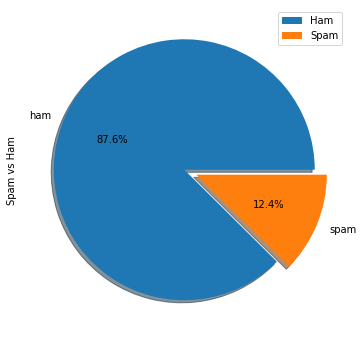

In [ ]:
spam_df["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

### Spam Word Cloud

In [ ]:
data = spam_df[spam_df['label'] == 'spam']
lower_text = data['text'].apply(lambda x:x.lower()).tolist()
spam_cloud = [sentence.translate(str.maketrans('', '', string.punctuation)) for sentence in lower_text]
spam_cloud = ''.join(spam_cloud)

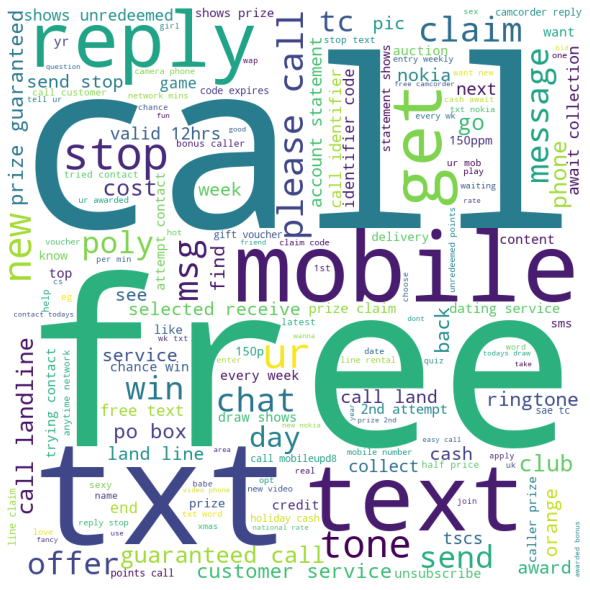

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color = 'white',
                      stopwords = stop_words, 
                      min_font_size = 10).generate(spam_cloud)

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

### Ham Word Cloud

In [ ]:
data = spam_df[spam_df['label'] == 'ham']
lower_text = data['text'].apply(lambda x:x.lower()).tolist()
ham_cloud = [sentence.translate(str.maketrans('', '', string.punctuation)) for sentence in lower_text]
ham_cloud = ''.join(ham_cloud)

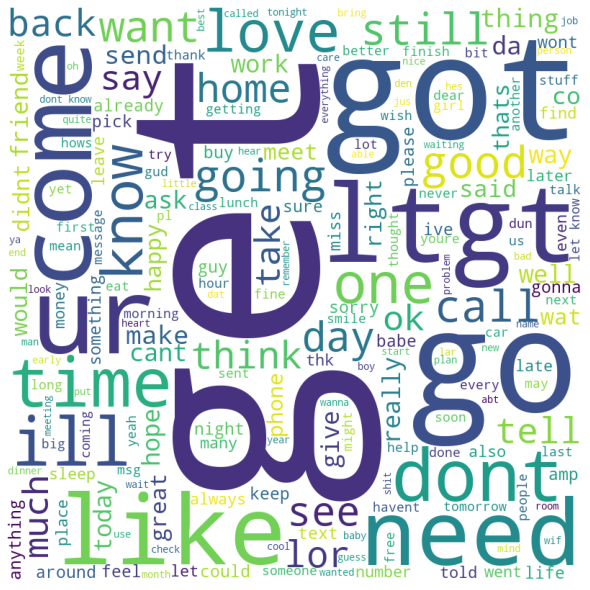

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color = 'white',
                      stopwords = stop_words, 
                      min_font_size = 10).generate(ham_cloud)

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

## Pre-trained Glove model

In [ ]:
X = spam_df.text.apply(lambda x: preprocess_text(x)).tolist()

print(len(X))
print(X[0])

5158
Go until jurong point crazy Available only in bugis great world la buffet Cine there got amore wat 


In [ ]:
y = np.array(spam_df['label'].apply(lambda x: 1 if x == "ham" else 0).tolist())

print(len(y))
print(y[0])

5158
1


### Split dataset into train test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Prepare Embedding Layer

In [ ]:
tokenizer = Tokenizer(num_words=8057)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

NameError: ignored

In [ ]:
len(X_train), len(X_test)

(4126, 1032)

### Padding the X into 100

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


### Glove Embedding

In [ ]:
embeddings_dictionary = dict()

#Download it from https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt
glove_file = open('drive/MyDrive/assignment_3/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100)) #This matrix will have 100 rows
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape


(6841, 100)

## Neural Network model

### LSTM

In [ ]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          684100    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 801,477
Trainable params: 117,377
Non-trainable params: 684,100
_________________________________________________________________
None


In [ ]:
history_lstm = lstm_model.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, validation_split=0.2)

score_test = lstm_model.evaluate(X_test, y_test, verbose=1)

Epoch 1/25
26/26 [==============================] - 10s 358ms/step - loss: 0.2421 - acc: 0.9333 - val_loss: 0.7089 - val_acc: 0.6889
Epoch 2/25
26/26 [==============================] - 9s 348ms/step - loss: 0.3414 - acc: 0.8621 - val_loss: 0.2899 - val_acc: 0.8656
Epoch 3/25
26/26 [==============================] - 9s 352ms/step - loss: 0.2238 - acc: 0.8815 - val_loss: 0.2482 - val_acc: 0.8656
Epoch 4/25
26/26 [==============================] - 11s 431ms/step - loss: 0.1819 - acc: 0.9030 - val_loss: 0.2120 - val_acc: 0.9128
Epoch 5/25
26/26 [==============================] - 9s 354ms/step - loss: 0.1660 - acc: 0.9109 - val_loss: 0.1898 - val_acc: 0.9370
Epoch 6/25
26/26 [==============================] - 9s 359ms/step - loss: 0.1286 - acc: 0.9552 - val_loss: 0.1212 - val_acc: 0.9673
Epoch 7/25
26/26 [==============================] - 9s 351ms/step - loss: 0.1265 - acc: 0.9533 - val_loss: 0.1805 - val_acc: 0.9431
Epoch 8/25
26/26 [==============================] - 9s 359ms/step - loss: 

In [ ]:
print("Test Score of LSTM:", score_test[0])
print("Test Accuracy of LSTM:", score_test[1])

Test Score of LSTM: 0.17013412714004517
Test Accuracy of LSTM: 0.942829430103302


### **LSTM model with 25 epochs gives a test Accuracy of 94.28 %**

### BI-LSTM

In [ ]:
bi_lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
bi_lstm_model.add(embedding_layer)
bi_lstm_model.add(Bidirectional(LSTM(128)))

bi_lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(bi_lstm_model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          684100    
                                                                 
 bidirectional_8 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 918,853
Trainable params: 234,753
Non-trainable params: 684,100
_________________________________________________________________
None


In [ ]:
history_bi_lstm = bi_lstm_model.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, validation_split=0.2)

score_test_bi_lstm = bi_lstm_model.evaluate(X_test, y_test, verbose=1)

Epoch 1/25
26/26 [==============================] - 26s 758ms/step - loss: 0.3857 - acc: 0.8612 - val_loss: 0.3187 - val_acc: 0.8705
Epoch 2/25
26/26 [==============================] - 20s 762ms/step - loss: 0.1896 - acc: 0.9288 - val_loss: 0.2105 - val_acc: 0.9443
Epoch 3/25
26/26 [==============================] - 18s 688ms/step - loss: 0.1256 - acc: 0.9618 - val_loss: 0.1163 - val_acc: 0.9685
Epoch 4/25
26/26 [==============================] - 20s 762ms/step - loss: 0.0927 - acc: 0.9709 - val_loss: 0.1002 - val_acc: 0.9746
Epoch 5/25
26/26 [==============================] - 18s 686ms/step - loss: 0.0786 - acc: 0.9745 - val_loss: 0.0994 - val_acc: 0.9770
Epoch 6/25
26/26 [==============================] - 18s 676ms/step - loss: 0.0689 - acc: 0.9797 - val_loss: 0.0911 - val_acc: 0.9758
Epoch 7/25
26/26 [==============================] - 18s 678ms/step - loss: 0.0582 - acc: 0.9833 - val_loss: 0.1039 - val_acc: 0.9709
Epoch 8/25
26/26 [==============================] - 18s 677ms/step - 

In [ ]:
print("Test Score of Bi LSTM:", score_test_bi_lstm[0])
print("Test Accuracy of Bi LSTM:", score_test_bi_lstm[1])

Test Score of Bi LSTM: 0.07131363451480865
Test Accuracy of Bi LSTM: 0.9844961166381836


### **BI-LSTM model with 25 epochs gives an Accuracy of 98.44 %**

### BI-LSTM with attention layer

In [ ]:
from keras.layers import Layer
from keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [ ]:
bi_lstm_model_with_attn = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
bi_lstm_model_with_attn.add(embedding_layer)
bi_lstm_model_with_attn.add(Bidirectional(LSTM(128, return_sequences=True)))
bi_lstm_model_with_attn.add(Bidirectional(LSTM(128, return_sequences=True)))
bi_lstm_model_with_attn.add(Attention(return_sequences=True)) # receive 3D and output 3D
bi_lstm_model_with_attn.add(LSTM(128))
bi_lstm_model_with_attn.add(Dense(1, activation='sigmoid'))

In [ ]:
bi_lstm_model_with_attn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(bi_lstm_model_with_attn.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 100)          684100    
                                                                 
 bidirectional_13 (Bidirecti  (None, 100, 256)         234496    
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 100, 256)         394240    
 onal)                                                           
                                                                 
 attention_5 (Attention)     (None, 100, 256)          356       
                                                                 
 lstm_19 (LSTM)              (None, 128)               197120    
                                                                 
 dense_8 (Dense)             (None, 1)               

In [ ]:
history_bi_lstm_with_attn = bi_lstm_model_with_attn.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, validation_split=0.2)

score_test_bi_lstm_with_attn = bi_lstm_model_with_attn.evaluate(X_test, y_test, verbose=1)

Epoch 1/25
26/26 [==============================] - 74s 2s/step - loss: 0.4549 - acc: 0.8521 - val_loss: 0.2628 - val_acc: 0.9322
Epoch 2/25
26/26 [==============================] - 61s 2s/step - loss: 0.3974 - acc: 0.8333 - val_loss: 0.6894 - val_acc: 0.2663
Epoch 3/25
26/26 [==============================] - 59s 2s/step - loss: 0.4579 - acc: 0.8336 - val_loss: 0.4000 - val_acc: 0.8656
Epoch 4/25
26/26 [==============================] - 59s 2s/step - loss: 0.3669 - acc: 0.8815 - val_loss: 0.3959 - val_acc: 0.8656
Epoch 5/25
26/26 [==============================] - 62s 2s/step - loss: 0.3674 - acc: 0.8815 - val_loss: 0.3983 - val_acc: 0.8656
Epoch 6/25
26/26 [==============================] - 59s 2s/step - loss: 0.3637 - acc: 0.8815 - val_loss: 0.4024 - val_acc: 0.8656
Epoch 7/25
26/26 [==============================] - 58s 2s/step - loss: 0.3652 - acc: 0.8815 - val_loss: 0.4014 - val_acc: 0.8656
Epoch 8/25
26/26 [==============================] - 57s 2s/step - loss: 0.3615 - acc: 0.88

In [ ]:
print("Test Score of Bi LSTM:", score_test_bi_lstm_with_attn[0])
print("Test Accuracy of Bi LSTM:", score_test_bi_lstm_with_attn[1])

Test Score of Bi LSTM: 0.07535004615783691
Test Accuracy of Bi LSTM: 0.9825581312179565


### **BI-LSTM model with attention layer and with 25 epochs gives a test Accuracy of 98.25 %**

## Comparing the performance result of Naive Bayes, LSTM, BI-LSTM, BI-LSTM with attention layer models

In [ ]:
def show_performance_plot(history):
  #show the model accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  #show model loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

### LSTM Model 

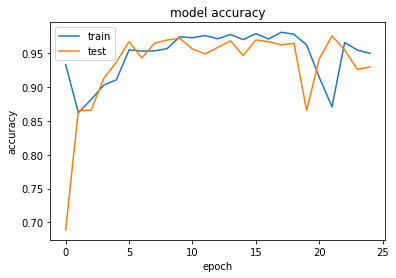

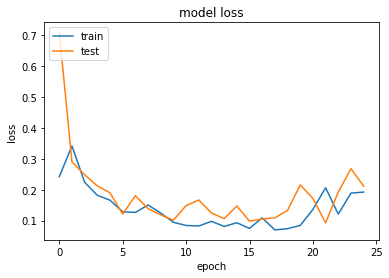

In [ ]:
show_performance_plot(history_lstm)

### Bi-LSTM model 

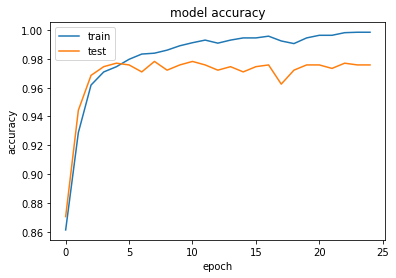

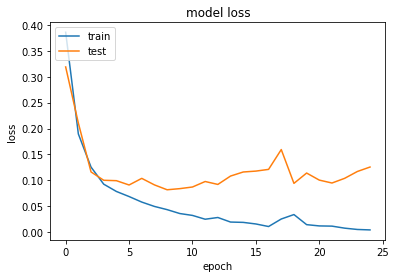

In [ ]:
show_performance_plot(history_bi_lstm)

### Bi-LSTM with attention Layer 

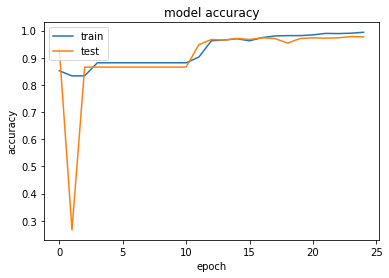

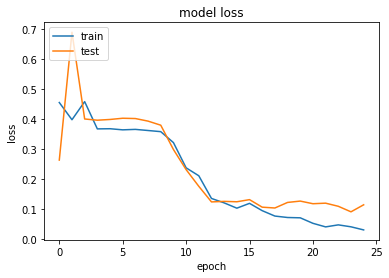

In [ ]:
show_performance_plot(history_bi_lstm_with_attn)

### Comparing the performance of all four models

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy, precision, recall and f1-score 
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)

    
    model_results_dict = {'accuracy':accuracy,
                         'precision':precision,
                         'recall':recall
                        }
    
    return model_results_dict

In [ ]:
naive_bayes_results = evaluate_model(NB, xtrain, ytrain )
model_1_results = evaluate_model(lstm_model, X_train, y_train)
model_2_results = evaluate_model(bi_lstm_model, X_train, y_train)
model_3_results = evaluate_model(bi_lstm_model_with_attn, X_train, y_train)

total_results = pd.DataFrame({'NAIVE-BAYES':naive_bayes_results, 'LSTM':model_1_results, 'BI-LSTM': model_2_results, 'BI-LSTM-Attn':model_3_results}).transpose()

total_results

,accuracy,precision,recall
NAIVE-BAYES,0.993075,0.983529,0.958716
LSTM,0.878333,0.878333,1.000000
BI-LSTM,0.994183,0.994777,0.998620
BI-LSTM-attn,0.992002,0.993405,0.997517


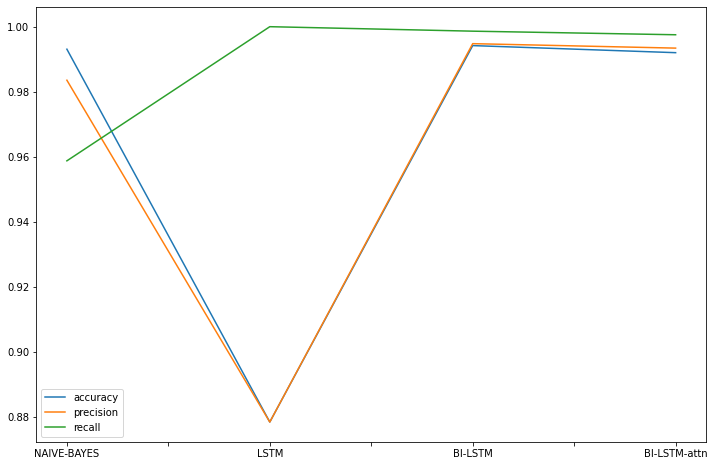

In [ ]:
total_results.plot(figsize=(12, 8))

## From the above plots, we can see that the BI_LSTM model gives a highest accuracy of 99.4 % and perform better than other models. Followed by Naive Bayes with an accuracy of 99.3 % 

### To Productionalize the model:
  

1.   Export the model as a pickle file
2.   Build an inference engine using model file
3.   Inference engine can be an rest end point or a batch application


